<a href="https://colab.research.google.com/github/anshulzutshi/deep_learning/blob/main/TL_DCRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Graph Neural Networks for Short-Term Highway Traffic Forecasting
Paper Authors: Tanwi Mallick, Prasanna Balaprakash, Eric Rask, Jane Macfarlane

Project Members: Emin Burak Onat, Eddie Song, Eric Zhang, Anshul Zutshi

In [ ]:
import torch
#@title Utilities for Testing
def rel_error(x, y):
    return torch.max(
        torch.abs(x - y)
        / (torch.maximum(torch.tensor(1e-8), torch.abs(x) + torch.abs(y)))
    ).item()

def check_error(name, x, y, tol=1e-3):
    error = rel_error(x, y)
    if error > tol:
        print(f'The relative error for {name} is {error}, should be smaller than {tol}')
    else:
        print(f'The relative error for {name} is {error}')

def check_acc(acc, threshold):
    if acc < threshold:
        print(f'The accuracy {acc} should >= threshold accuracy {threshold}')
    else:
        print(f'The accuracy {acc} is better than threshold accuracy {threshold}')

# Introduction


Highway traffic predictions are essential for intelligent transportation systems and rely upon historical data to make future predictions. The motivation behind this paper is modeling and forecasting highway traffic when there is not a significant corpus of historical data to make these predictions. As a result, they implement transfer learning techniques to train a model on a different part of the highway network to predict highway traffic that lacks historical data.


# DCRNN Model

DCRNN or diffusion convolutional recurrent neural network is a state of the art graph neural network for highway network forecasting. Recently, there have been significant developments in deep learning methods including deep belief networks, stacked autoencoders, and recurrent network variants that are able to capture long-term temporal changes but lack the ability to capture the spatial dependencies of a highway network. Attempts have been made to use convolutional neural networks with recurrent units by converting spatial temporal traffic data to images, however, this violates the non-Euclidean property of network data because pixels have an impact on their neighbors. As a result, DCRNN was proposed due to its ability to capture spatial correlation using a diffusion process on a graph and temporal dependencies using a sequence-to-sequence recurrent neural network.

The DCRNN model is an encoder-decoder neural network that performs sequence-to-sequence learning to execute multistep traffic state forecasting. A variant of recurrent neural networks, gated recurrent units (GRUs), is used to design the encoder-decoder architecture. The matrix multiplication in GRUs is replaced with a different convolution operation to create the DCRNN cell. In an L layered DCRNN architecture, each layer has R DCRNN cells, each of which can be defined by the following sets of equations:

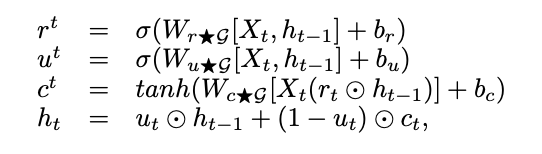

rt, ut, and ct: reset gate, update gate, and cell state at time t, respectively.

Xt and ht: input and final state at time t, respectively.

★G: diffusion convolution

Wr, Wu, and Wc: parameters for the corresponding filters.

★G operation over input graph signal X and convolutional filter W is defined as:


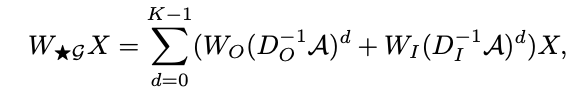

K: maximum number of diffusion steps

DO-1A and DI-1A: transition matrix of the diffusion process and the reverse one, respectively

DO and DI: in-degree and out-degree diagonal matrices, respectively

WO and WI: the learnable filters for the bidirectional diffusion process


The in-degree and out-degree diagonal matrices provide the capability to capture the effect of the upstream and downstream traffic. The driving distances between sensor locations are used to build the adjacency matrix A and a threshold τ parameter is used to sparsify A. During the training of DCRNN, a minibatch of time series sequence each of length P from historical time series data X, is given as an input to the encoder. The decoder receives a fixed-length hidden representation of the data from the encoder and forecasts the next Q time steps for each sequence in the minibatch. The layers of DCRNN are trained by using backpropagation and learn weight matrices in the above equation by using MAE as a loss function.


# Vanishing/Exploding Gradient Problem

The vanishing gradient problem occurs when the gradients in the backpropagation algorithm for the RNN become very small, making it difficult to update the weights of the network. Conversely, the exploding gradient problem occurs when the gradients become very large, leading to unstable training. These problems can significantly affect the performance of the model and make it difficult to learn long-term dependencies.

GRUs address these problems by using gating mechanisms that control the flow of information within the network. The gating mechanism regulates the information flow by selectively allowing certain information to pass through while discarding or modifying other information. This selective gating mechanism helps the GRU to better capture long-term dependencies in the data, making it more effective for modeling sequential data.

Additionally, GRUs are computationally efficient and require fewer parameters than other RNN variants like Long Short-Term Memory (LSTM), which can be beneficial in reducing the training time and memory requirements of the model.



# TL-DRCNN

DCRNN cannot do transfer learning because it learns location-specific spatial temporal patterns in the data and requires the same highway network for both training and inference. As a result, we utilize TL-DCRNN which is a DCRNN with transfer learning capabilities. TL-DCRNN partitions a large highway network into several regions and region-specific graphs and temporal data are used to train the model at each epoch. This results in the location-specific traffic patterns to be marginalized as the model attempts to learn the traffic dynamics based on graph connectivity and temporal pattern alone. TL-DCRNN can learn from different regions on the highway network and apply the model to unseen regions on the network to make short-term highway traffic predictions.



DCRNN becomes location-specific because of the presence of the weighted adjacency matrix A in the diffusion step. As a result, the convolution filter W is dependent on the given A, which is kept constant throughout the training process. If graph A and the corresponding time series data are changed during the training process then we can make diffusion convolution filters generic as opposed to location-specific. The resulting model would then be more generalizable and used to forecast traffic on unseen graphs.

The inputs of the model consist of 3 files:

distances.csv: Driving distances between each speed sensor in the network.

speed.h5: Historical time-series data of speed between adjacent sensors. It is essentially a dataset of speed readings taken from the speed sensors over time.

Adjacency matrix: Pairwise driving distances between the sensor locations. The  adjacency matrix is sparsified using a thresholded Gaussian kernel to make the matrix easier to work with computationally.


# Data Preparation

Download the traffic data files for entire California '[speed.h5](https://anl.box.com/s/7hfhtie02iufy75ac1d8g8530majwci0)', adjacency matrix '[adj_mat.pkl](https://anl.box.com/s/4143x1repqa1u26aiz7o2rvw3vpcu0wp)' and distance between sensors 'distances.csv', and keep in the data/input_files/ folder.

In [ ]:
import sys, os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/2. UCB_Classes/EECS 282/EECS 182 282 Final Project /TL-DCRNN/install'

/content/drive/MyDrive/2. UCB_Classes/EECS 282/EECS 182 282 Final Project /TL-DCRNN/install


In [ ]:
!pip install colab-xterm
%load_ext colabxterm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.2 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Fri May  5 05:39:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Uninstall the current CUDA version

!sudo apt-get --purge remove cuda nvidia* libnvidia-*
!sudo dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!sudo apt-get remove cuda-*
!sudo apt autoremove

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libnvidia-encode-418-server' for glob 'libnvidia-*'
Note, selecting 'libnvidia-compute-450-server' for glob 'libnvidia-*'
Note, selecting 'libnvidia-gl-460-server' for glob 'libnvidia-*'
Note, selecting 'libnvidia-encode' for glob 'libnvidia-*'
Note, selecting 'libnvidia-extra-525-server' for glob 'libnvidia-*'
Note, selecting 'libnvidia-fbc1-450-server' for glob 'libnvidia-*'
Note, selecting 'libnvidia-compute-440-server' for glob 'libnvidia-*'
Note, selecting 'libnvidia-gl-450-server' for glob 'libnvidia-*'
Note, selecting 'libnvidia-gl-515-server' for glob 'libnvidia-*'
Note, selecting 'libnvidia-compute-390' for glob 'libnvidia-*'
Note, selecting 'libnvidia-ifr1-418-server' for glob 'libnvidia-*'
Note, selecting 'libnvidia-fbc1-440-server' for glob 'libnvidia-*'
Note, selecting 'libnvidia-container-tools' for glob 'libnvidia-*'
Note, selecting 'libnvidia-compute-418' for

In [ ]:
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

In [ ]:
# # Inside the terminal window run the following commands to install TensorRT. YOU MIGHT NEED TO RUN THE COMMANDS THAT ARE SUGGESTED BY THE TERMINAL

# sudo apt update
# sudo apt upgrade -y

# mkdir install ; cd install
# wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin
# sudo mv cuda-ubuntu1804.pin /etc/apt/preferences.d/cuda-repository-pin-600
# sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
# sudo add-apt-repository "deb http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/ /"
# sudo apt-get update
# sudo apt-get -y install cuda-10-2

# sudo dpkg -i libcudnn7_7.6.5.32-1+cuda10.2_amd64.deb
# sudo dpkg -i libcudnn7-dev_7.6.5.32-1+cuda10.2_amd64.deb

# cat /usr/include/x86_64-linux-gnu/cudnn_v*.h | grep CUDNN_MAJOR -A 2

# sudo dpkg -i nv-tensorrt-repo-ubuntu1804-cuda10.2-trt7.0.0.11-ga-20191216_1-1_amd64.deb
# sudo apt update
# sudo apt install tensorrt libnvinfer7




# ------------------------------------------------
# DON'T RUN THESE
# ------------------------------------------------

# # Installing CUDA 10.0
# wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
# sudo dpkg --force-confold -i cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
# sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
# sudo apt-get update
# wget http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
# sudo apt install -y ./nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
# sudo apt-get update

# # Install NVIDIA driver
# sudo apt-get -y install nvidia-driver-418

# # Install development and runtime libraries (~4GB)
# sudo apt-get install -y cuda libcudnn7=7.6.2.24-1+cuda10.0 libcudnn7-dev=7.6.2.24-1+cuda10.0 --allow-change-held-packages

# nvcc --version


# sudo dpkg -i "/content/drive/MyDrive/2. UCB_Classes/EECS 282/EECS 182 282 Final Project /TL-DCRNN/nv-tensorrt-repo-ubuntu1804-cuda11.1-trt7.2.3.4-ga-20210226_1-1_amd64.deb"
# sudo apt-key add /var/nv-tensorrt-repo-ubuntu1804-cuda11.1-trt7.2.3.4-ga-20210226/7fa2af80.pub

# sudo apt-get update

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0


In [ ]:
%cd '../data'

/content/drive/MyDrive/2. UCB_Classes/EECS 282/EECS 182 282 Final Project /TL-DCRNN/data


In [ ]:
import h5py
import pandas as pd

In [ ]:
# Load the HDF5 file
data = pd.read_hdf('input_files/speed.h5', key='df')
df = pd.DataFrame(data)


In [ ]:
!python hdf_to_tfrecord.py --config_filename input_files/tf_record_config.yaml

2023-05-05 06:09:22.607055: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
^C


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import tensorflow as tf
import yaml
import pandas as pd
import glob
import numpy as np

from input_files.utils import load_graph_data
from input_files.utils import generate_seq2seq_data
from input_files.utils import train_val_test_split
from input_files.utils import StandardScaler
from traffic_tfrecords import write_as_tfrecords
from traffic_tfrecords import _parse_record_fn

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'



def main():
    with open('input_files/tf_record_config.yaml') as f:
        supervisor_config = yaml.safe_load(f)

        # Data preprocessing
        traffic_df_filename = supervisor_config['data']['hdf_filename']
        df_data = pd.read_hdf(traffic_df_filename)
        sensor_ids = list(df_data.columns)
        supervisor_config['model']['num_nodes'] = num_nodes = len(sensor_ids)


        validation_ratio = supervisor_config.get('data').get('validation_ratio')
        test_ratio = supervisor_config.get('data').get('test_ratio')
        df_train, df_val, df_test = train_val_test_split(df_data, val_ratio=validation_ratio, test_ratio=test_ratio)

        batch_size = supervisor_config.get('data').get('batch_size')
        val_batch_size = supervisor_config.get('data').get('val_batch_size')
        test_batch_size = supervisor_config.get('data').get('test_batch_size')
        horizon = supervisor_config.get('model').get('horizon')
        seq_len = supervisor_config.get('model').get('seq_len')
        scaler = StandardScaler(mean=df_train.values.mean(), std=df_train.values.std())

        # In case of multiple partitions
        sensor_ids_filesname = supervisor_config.get('data').get('sensor_ids')
        loop_df = pd.read_csv(sensor_ids_filesname)
        loop_ids = loop_df['sensor_id'].astype('str').tolist()
        graph_partition_filesname = supervisor_config.get('data').get('graph_partitions')
        partition = np.genfromtxt(graph_partition_filesname, dtype=int, delimiter="\n", unpack=False)
        max_node =  max(np.bincount(partition))

        folder = 'TFrecords/'
        if not os.path.exists(folder):
            os.makedirs(folder)

        partition_ids = np.unique(partition)
        for p in partition_ids:

            indices = partition==p
            part_df = loop_df[indices]
            loop_ids = part_df['sensor_id'].astype('str').tolist()
            h5files = df_data[loop_ids]
            num_nodes = len(loop_ids)
            if num_nodes < max_node:
                pad = max_node - num_nodes
                solution = (['%i' %i for i in range(pad)])
                d = dict.fromkeys(solution, 0)
                h5files = h5files.assign(**d)
            df_train, df_val, df_test = train_val_test_split(h5files, val_ratio=validation_ratio, test_ratio=test_ratio)


            x_train, y_train = generate_seq2seq_data(df_train, batch_size, seq_len, horizon, max_node, 'train', scaler)
            x_val, y_val = generate_seq2seq_data(df_val, val_batch_size, seq_len, horizon, max_node, 'val', scaler)
            x_test, y_test = generate_seq2seq_data(df_test, test_batch_size, seq_len, horizon, max_node, 'test', scaler)

            # Write TFrecords file
            write_as_tfrecords(x_train, y_train, 'train_' + str(p), './%s'%folder, num_shards=1)
            write_as_tfrecords(x_val, y_val , 'val_'+ str(p), './%s'%folder)
            write_as_tfrecords(x_test, y_test , 'test_' + str(p), './%s'%folder)



if __name__ == '__main__':
    main()

# Diffusion Convolution

---



One important part of the DCRNN model is the use of diffusion convolution, in which a kernel or filter is applied to a graph in a way that resembles a diffusion process: each vertex’s value in a certain time step is a sum of weighted contribution from its neighboring vertices from the last time step. Typically, in image diffusion, a Gaussian filter is used to preserve the local structures and details as well as smoothing the whole image. However, when dealing with graphs, the graph’s connectivity and local structures must be considered when choosing the type of the filter, and there are several options what we can consider for the filter of a DCRNN cell: the normalized laplacian filter, the random walk filter, and the dual random walk filter. We will implement the Laplacian filter and the random walk filter in this homework.


The simplest graph diffusion filter is the normalized Laplacian filter, normalized Laplacian of the graph adjacency matrix is used as a diffusion filter. The normalized laplacian filter has the advantage of simplicity, respecting the graph’s local geometric structures, and works well in general with graphs thats emphasizes connectivity.


# The Normalized Laplacian Filter

Recall that when dealing with graphs, the imbalance of vertex-degrees can have undersirable effects on the graph’s adjacency matrix: a vertex with a large degree will result in a large diagonal entry in the matrix, which, in turn, will produce a large eigenvalue that dominates the matrix’s properties. To mitigate this problem, before working with the graph, we will need to normalize its adjacency matrix so that each vertex’s influence is around the same level. This is accomplished by calculating the the normalized adjacent matrix ( D^-1/2 A D^-1/2) and the normalized laplacian matrix (D^-1/2 (D-A) D^-1/2). Complete the implementation of calculate_normalized_laplacian(adj) which will return the laplacian matrix given an adjacency matrix as input.

In [ ]:
def calculate_normalized_laplacian(adj):
    """
    # L = D^-1/2 (D-A) D^-1/2 = I - D^-1/2 A D^-1/2
    # D = diag(A 1)
    :Input adj: the adjacency matrix of interest
    :return the normalized laplacian matrix of the adjacency matrix
    """
    adj = sp.coo_matrix(adj)
    #######################################################################
    # YOUR CODE HERE
    #######################################################################
    normalized_laplacian = ?
    #######################################################################
    return normalized_laplacian


SyntaxError: ignored

In [ ]:
x = torch.tensor([[0., 1., 0., 0.],
                  [1., 0., 1., 1.],
                  [0., 1., 0., 0.],
                  [0., 1., 0., 0.]])

y = torch.tensor([[1., -1.73205, 0., 0.],
                  [-1.73205, 1., -1.73205, -1.73205],
                  [0., -1.73205, 1., 0.],
                  [0., -1.73205, 0., 1.]])

check_error('normalized laplacian', calculate_normalized_laplacian(x), y)

x = torch.tensor([[0., 0., 0., 0., 1.],
                  [0., 0., 1., 1., 1.],
                  [0., 1., 0., 0., 1.],
                  [0., 1., 0., 0., 1.],
                  [1., 1., 1., 1., 0.]])

y = torch.tensor([[1., 0., 0., 0., -2.],
                  [0., 1., -2.44948, -2.44948, -3.46410],
                  [0., -2.44948, 1., 0., -2.82842],
                  [0., -2.44948, 0., 1., -2.82842],
                  [-2., -3.46410, -2.82842, -2.82842, 1.]])

check_error('normalized laplacian', calculate_normalized_laplacian(x), y)

# The Random Walk Filter

Another option for the diffusion filter that we will consider in this homework is the random walk filter, based on the idea of random walks: particles move randomly in space, with its position in a given time step only determined by its position in the previous time step and the local geometric structures at that location.
In the context of highway traffic prediction, the random walk filter treats each car as a particle in the highway space, and the traffic moves randomly in the network of roads with its position at any given time step is determined by its position in the last timestep and the local connections (highways, junctions) of the graph.

To construct the random walk matrix from a adjacency matrix RW = D^-1A


In [ ]:
def calculate_random_walk_matrix(adj_mx):
    adj_mx = sp.coo_matrix(adj_mx)
    # Construct the inverse of the degree matrix. Notice that for some vertices, the degree can be 0.
    #######################################################################
    # YOUR CODE HERE
    #######################################################################
    d_mat_inv = ?
    #######################################################################
    random_walk_mx = d_mat_inv.dot(adj_mx).tocoo()
    return random_walk_mx


# Graph Partitioning

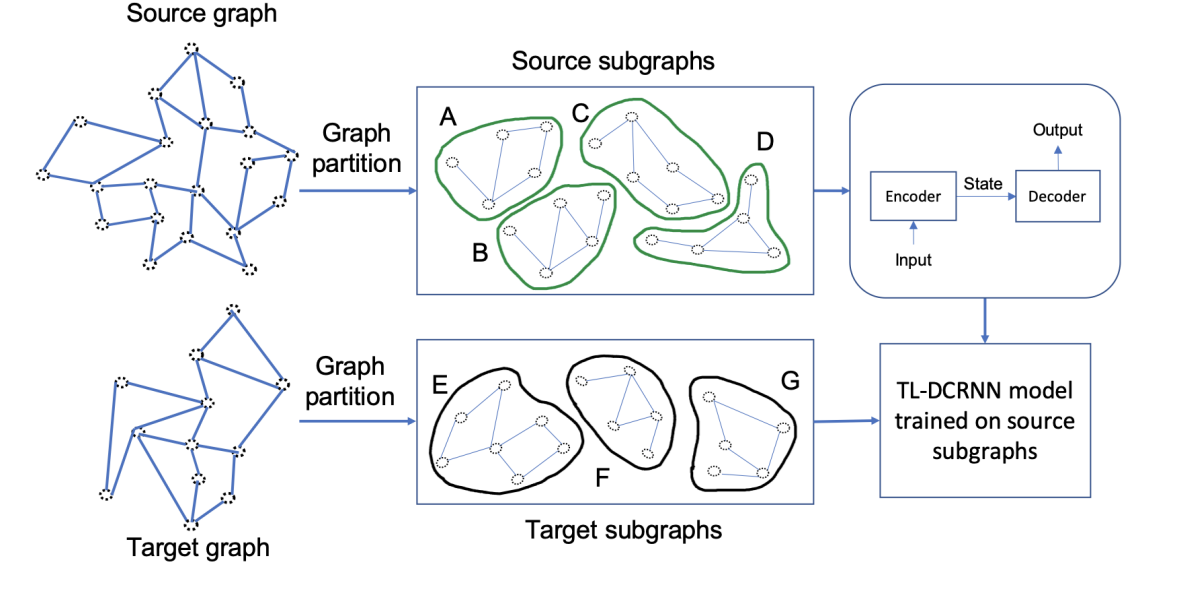

TL-DCRNN partitions the large highway network with historical data into a number of subgraphs using a graph partitioning library, METIS. These subgraphs are used to train the encoder-decoder architecture with diffusion convolutional recurrent neural network cells. Given an unseen graph during inference, TL-DCRNN partitions the graph and uses the trained model for short-term traffic forecasting.


# Model Training

Go to /model/dcrnn_cell.py and implement diffusion convolution.

Explain config file

In [ ]:
# Run the TL-DCRNN model

!python dcrnn_train.py --config_filename=data/dcrnn_config_32transfer.yaml

# Model Evaluation

## Loss Function

The choice of loss functions is vital to the training and validation of a neural network, fill in the code below to implement the loss function for the DCRNN model. (Hint: choose among mean squared loss (MSE), mean absolute loss (MAE), and cross-entropy loss)

In [ ]:
def loss_fn(graph):
     """
    # MSE = 1/n Sum_{i=1}^{n}(v_i-v’_i)^2
    # MAE = 1/n Sum_{i=1}^{n}|v_i-v’_i|
    :Input graph: the predicted weight of the vertices in the graph
    :return: a scalar representing the loss
    """
    #######################################################################
    # YOUR CODE HERE
    #######################################################################
    loss = ?
    #######################################################################
    return loss


In [ ]:
a = torch.rand(5)
b = torch.rand(5)
accuracy = (torch.nn.functional.l1_loss(a,b) - loss_fn(a,b))/(torch.nn.functional.l1_loss(a,b) + loss_fn(a,b))
check_acc(accuracy, 1e-3)

a = torch.rand(5)
b = torch.rand(5)
accuracy = (torch.nn.functional.l1_loss(a,b) - loss_fn(a,b))/(torch.nn.functional.l1_loss(a,b) + loss_fn(a,b))
check_acc(accuracy, 1e-3)

From the exercise above you should noticed that MAE is the expected loss function. This is because unlike MSE, which is prone to outliers, MAE is less sensitive to the extremes. Due to the high-variability of highway traffic, MAE is a better fit for the loss function.